### Imports, settings, globals

In [1]:
### Set CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
from typing import Dict, List, Callable, Tuple, List
import numpy as np
import tqdm
import torch #
from torch.utils.data import DataLoader, default_collate
from torch import Tensor, nn #
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from copy import deepcopy


sys.path.append('../')
from data_utils import get_train_loader, get_eval_data
from model.unet import get_unet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [3]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

### UNet Models

In [4]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr

#unet_name = 'monai-64-4-4'
unet_name = 'default-8'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = None if unet_name == 'swinunetr' else int(args[1])
if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()


### Data

In [30]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = True
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = 'all'


raw_data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)


print(f'\nAvailable datasets are: {list(raw_data.keys())}')

loading dataset
loading all case properties


loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties

Available datasets are: ['train', 'val', 'A', 'B', 'C', 'D']


In [6]:
# get data
train_loader, val_loader = get_train_loader(
    training='unet', 
    cfg=cfg
)

loading dataset
loading all case properties


loading dataset
loading all case properties


### Slice Wise uncertainty Measures

Accuracy-Rejection (or [E]-AURC) get it from here: https://github.com/IML-DKFZ/values/blob/main/evaluation/metrics/aurc.py

AUROC 


In [7]:
from typing import List, Tuple

import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, default_collate
from torchmetrics import (
    SpearmanCorrCoef, 
    AUROC,
    ROC,
    Dice
)
from torchmetrics.utilities.compute import _auc_compute_without_check
import numpy as np


from model.mahalanobis_adatper import BatchNormMahalanobisDetector, PoolingMahalanobisDetector
from model.wrapper import BatchNormMahalanobisWrapper, PoolingMahalanobisWrapper


class AUROC(nn.Module):
    def __init__(
        self, 
        ret_curves: bool = True
    ):
        super().__init__()
        # args
        self.ret_curves = ret_curves
        # metrics
        self.roc_values = ROC(task='binary')

    @torch.no_grad()
    def auroc(
        self,
        confids: Tensor,
        target: Tensor
    ):
        
        confids = (confids - confids.min()) / (confids.max() - confids.min())
        fpr, tpr, _ = self.roc_values(
            confids,
            target
        )

        ret = _auc_compute_without_check(
            x=fpr,
            y=tpr,
            direction=1.0
        )

        if self.ret_curves:
            return ret, fpr, tpr
        else:
            return ret

    @torch.no_grad()
    def forward(
        self,
        confids: Tensor,
        target: Tensor
    ):
        return self.auroc(confids=confids, target=target)



class EAURC(nn.Module):
    def __init__(
        self,
        ret_curves: bool = True
    ):
        super().__init__()
        # args
        self.ret_curves = ret_curves
        
    @torch.no_grad()
    def _rc_curve_stats(
        self,
        confids: np.array, 
        risks: np.array
    ) -> Tuple[List[float], List[float], List[float]]:
        coverages = []
        selective_risks = []
        assert (
            len(risks.shape) == 1 and len(confids.shape) == 1 and len(risks) == len(confids)
        )

        n_samples = len(risks)
        idx_sorted = np.argsort(confids)

        coverage = n_samples
        error_sum = sum(risks[idx_sorted])

        coverages.append(coverage / n_samples)
        selective_risks.append(error_sum / n_samples)

        weights = []

        tmp_weight = 0
        for i in range(0, len(idx_sorted) - 1):
            coverage = coverage - 1
            error_sum = error_sum - risks[idx_sorted[i]]
            tmp_weight += 1
            if i == 0 or confids[idx_sorted[i]] != confids[idx_sorted[i - 1]]:
                coverages.append(coverage / n_samples)
                selective_risks.append(error_sum / (n_samples - 1 - i))
                weights.append(tmp_weight / n_samples)
                tmp_weight = 0

        # add a well-defined final point to the RC-curve.
        if tmp_weight > 0:
            coverages.append(0)
            selective_risks.append(selective_risks[-1])
            weights.append(tmp_weight / n_samples)

        return coverages, selective_risks, weights

    @torch.no_grad()
    def _aurc(
        self,
        confids: np.array, 
        risks: np.array
    ):
        _, risks, weights = self._rc_curve_stats(confids=confids, risks=risks)

        ret = sum(
            [(risks[i] + risks[i + 1]) * 0.5 * weights[i] for i in range(len(weights))]
        )

        if self.ret_curves:
            return ret, risks, weights
        else:
            return ret

    @torch.no_grad()
    def eaurc(
        self,
        score: Tensor, 
        risks: Tensor
    ):
        """Compute normalized AURC, i.e. subtract AURC of optimal CSF (given fixed risks)."""
        n = len(risks)
        score = score.numpy()
        score = (score - score.min()) / (score.max() - score.min())
        confids = 1 - score
        risks = risks.numpy()
        # optimal confidence sorts risk. Asencding here because we start from coverage 1/n
        selective_risks = np.sort(risks).cumsum() / np.arange(1, n + 1)
        aurc_opt = selective_risks.sum() / n
        ret, risks, weights = self._aurc(confids=confids, risks=risks)
        if self.ret_curves:
            risks   = torch.flip(torch.tensor(risks)[:-1], [0])
            weights = torch.cumsum(torch.flip(torch.tensor(weights), [0]), 0)
            return ret - aurc_opt, ret, risks, weights
        else:
            return ret - aurc_opt, ret

    @torch.no_grad()
    def forward(
        self,
        score: Tensor,
        risks: Tensor
    ):
        return self.eaurc(score=score, risks=risks)

In [8]:
def get_auroc_mahalanobis(
    wrapper: nn.Module,
    iid_data: Dataset,
    ood_data: Dataset,
    device: str = 'cuda:0',
):
    auroc = AUROC()
    
    batch_size = 32
    iid_loader = DataLoader(iid_data, batch_size=batch_size, shuffle=False)
    ood_loader = DataLoader(ood_data, batch_size=batch_size, shuffle=False)

    score_iid = []
    for batch in iid_loader:
        input_ = batch['input'].to(device)
        _ = wrapper(input_)
        score_iid.append({
            adapter.swivel: adapter.batch_distances.cpu().view(-1)
            for adapter in wrapper.adapters
        })
    target_iid = torch.zeros(len(iid_data))


    score_ood = []
    for batch in ood_loader:
        input_ = batch['input'].to(device)
        _ = wrapper(input_)
        score_ood.append({
            adapter.swivel: adapter.batch_distances.cpu().view(-1)
            for adapter in wrapper.adapters
        })
    target_ood = torch.ones(len(ood_data))
    
    score = {
        swivel: torch.cat([conf[swivel] for conf in score_iid + score_ood])
        for swivel in score_iid[0].keys()
    }
    
    target = torch.cat([target_iid, target_ood]).long()


    ret = {
        swivel: auroc(confids=score[swivel], target=target)
        for swivel in score.keys()
    }

    return ret


def get_eaurc_mahalanobis(
    wrapper: nn.Module,
    data: Dataset,
    net_out: str,
    device: str = 'cuda:0',
):
    eaurc = EAURC()
    dice = Dice(
        num_classes=1 if net_out == 'brain' else 4,
        average='micro',
        mdmc_average='samplewise',
        ignore_index=0 if net_out == 'heart' else None
    )
    batch_size = 32

    loader = DataLoader(data, batch_size=batch_size, shuffle=False)
    
    score, risk = [], []
    for batch in loader:
        # grab data
        input_ = batch['input'].to(device)
        target = batch['target'].to(device).long()
        target[target == -1] = 0
        # inference
        output = wrapper(input_)
        if net_out == 'brain':
            segmap = (torch.sigmoid(output) > 0.5) * 1
        elif net_out == 'heart':
            segmap = torch.argmax(output, dim=1, keepdims=True)
        # collect risk and score
        risk.append(
            torch.tensor([1 - dice(s, t) for s,t in zip(segmap, target)]).cpu()
        )
        score.append({
            adapter.swivel: adapter.batch_distances.cpu().view(-1)
            for adapter in wrapper.adapters
        })
    # aggregate results
    risk = torch.cat(risk)
    score = {
        swivel: torch.cat([conf[swivel] for conf in score])
        for swivel in score[0].keys()
    }
    # compute eaurc
    ret = {
        swivel: eaurc(score=score[swivel], risks=risk)
        for swivel in score.keys()
    }

    return ret

### AUROC MAHALANOBIS TEST

In [9]:
# Wrappers

device = 'cuda:0'
unet.to(device)

batchnorm_detector = BatchNormMahalanobisDetector(
    swivel='up3.0.conv_path.0.bn',
    device=device,
)
batchnorm_detector.train()
batchnorm_wrapper = BatchNormMahalanobisWrapper(
    model=unet,
    adapters=nn.ModuleList([batchnorm_detector])
)
batchnorm_wrapper.hook_adapters()
batchnorm_wrapper.eval()
print()


pooling_detector = PoolingMahalanobisDetector(
    swivel='up3.0.conv_path.0.bn',
    device=device,
    ledoitWolf=False
)
pooling_detector.train()
pooling_wrapper = PoolingMahalanobisWrapper(
    model=unet,
    adapters=nn.ModuleList([pooling_detector])
)
pooling_wrapper.hook_adapters()
for _ in tqdm.tqdm(range(250)):
    batch = next(train_loader)
    x = batch['data'].to(device)
    _ = pooling_wrapper(x)
pooling_detector.fit()
_ = pooling_detector.eval()


100%|██████████| 250/250 [01:01<00:00,  4.04it/s]


In [31]:
results = {
    'pooling': {
        'auroc': {},
        'eaurc': {}
    },
    'batchnorm': {
        'auroc': {},
        'eaurc': {}
    }
}
for domain in raw_data:
    if domain == 'train':
        continue
    if domain != 'val':

        pooling_auroc = get_auroc_mahalanobis(
            wrapper=pooling_wrapper,
            iid_data=raw_data['val'],
            ood_data=raw_data[domain],
            device=device
        )
        results['pooling']['auroc'][domain] = pooling_auroc['up3.0.conv_path.0.bn']

        batchnorm_auroc = get_auroc_mahalanobis(
            wrapper=batchnorm_wrapper,
            iid_data=raw_data['val'],
            ood_data=raw_data[domain],
            device=device
        )
        results['batchnorm']['auroc'][domain] = batchnorm_auroc['up3.0.conv_path.0.bn']

    eaurc_pooling = get_eaurc_mahalanobis(
        wrapper=pooling_wrapper,
        data=raw_data[domain],
        net_out=DATA_KEY,
        device=device
    )
    results['pooling']['eaurc'][domain] = eaurc_pooling['up3.0.conv_path.0.bn']

    eaurc_batchnorm = get_eaurc_mahalanobis(
        wrapper=batchnorm_wrapper,
        data=raw_data[domain],
        net_out=DATA_KEY,
        device=device
    )
    results['batchnorm']['eaurc'][domain] = eaurc_batchnorm['up3.0.conv_path.0.bn']

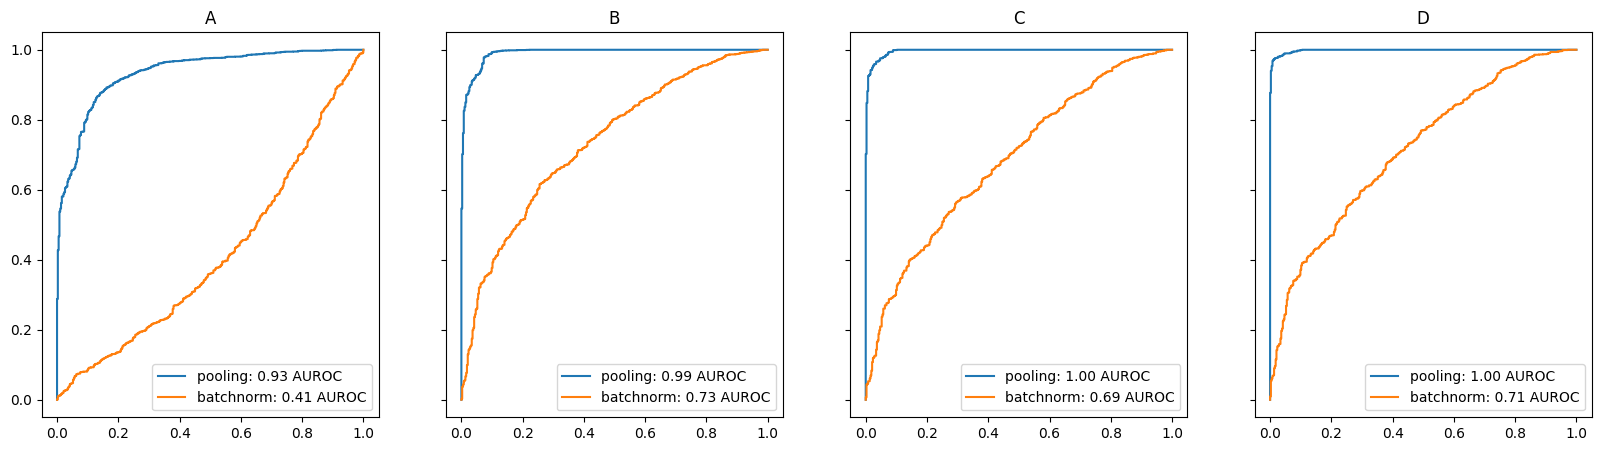

In [35]:
task = 'auroc'
methods = ['pooling', 'batchnorm']
fig, axes = plt.subplots(1, len(raw_data)-2, figsize=((len(raw_data)-2)* 5, 5),sharey=True)

plt_ctr = 0
for i, domain in enumerate(raw_data.keys()):
    if domain in ['train', 'val']:
        continue
    for method in methods:


        auroc, fpr, tpr = results[method][task][domain]
        axes[plt_ctr].plot(fpr, tpr, label=f'{method}: {auroc:.2f} AUROC')
    axes[plt_ctr].legend()
    axes[plt_ctr].title.set_text(f'{domain}')
    plt_ctr += 1

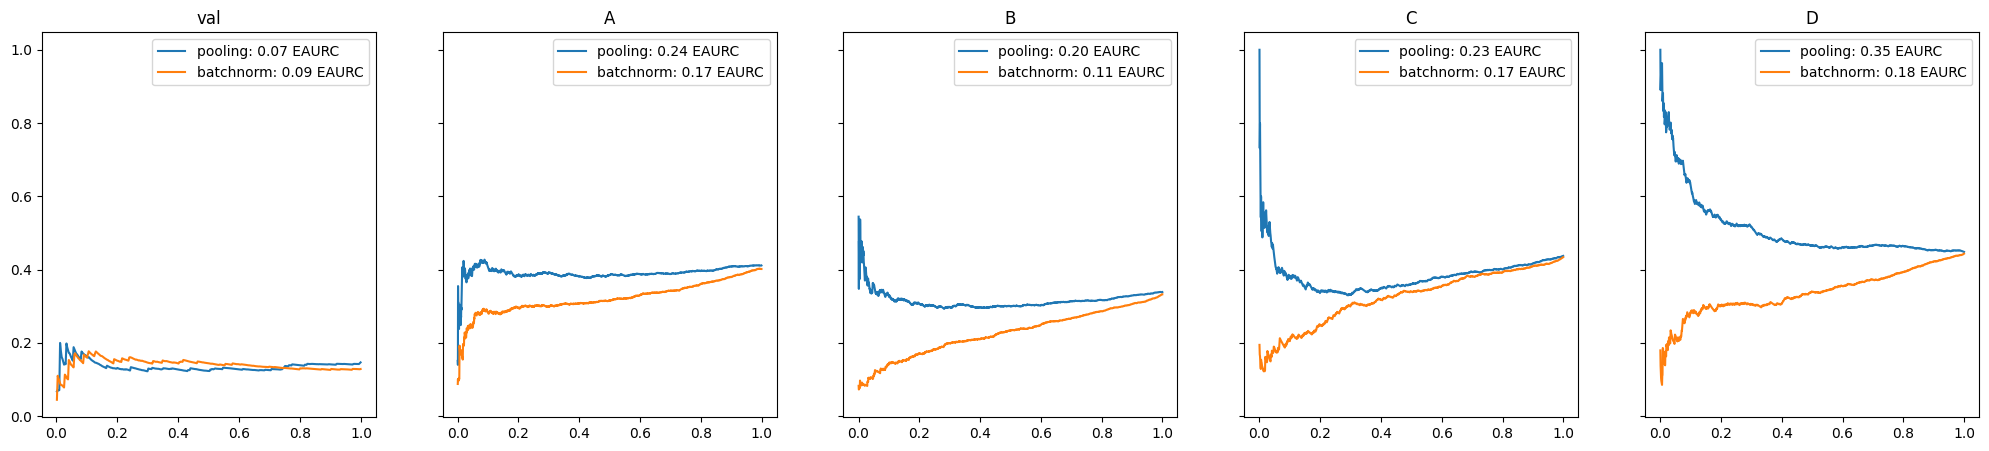

In [34]:
task = 'eaurc'
methods = ['pooling', 'batchnorm']

fig, axes = plt.subplots(1, len(raw_data)-1, figsize=((len(raw_data)-1)* 5, 5), sharey=True)

plt_ctr = 0
for i, domain in enumerate(raw_data.keys()):
    if domain == 'train':
        continue
    for method in methods:

        res, aurc, risk, weight = results[method][task][domain]
        axes[plt_ctr].plot(weight, risk, label=f'{method}: {res:.2f} EAURC')
    
    best_eaurc = torch.cumsum(torch.sort(risk)[0], 0) / np.arange(1, len(y) + 1)
    axes[plt_ctr].legend()
    axes[plt_ctr].title.set_text(f'{domain}')
    plt_ctr += 1

In [87]:
# Batch Norm

device = 'cuda:0'
unet.to(device)

batchnorm_detector = BatchNormMahalanobisDetector(
    swivel='up3.0.conv_path.0.bn',
    device=device,
)
batchnorm_detector.train()
batchnorm_wrapper = BatchNormMahalanobisWrapper(
    model=unet,
    adapters=nn.ModuleList([batchnorm_detector])
)

batchnorm_wrapper.hook_adapters()
batchnorm_wrapper.eval()

# batchnorm_auroc = get_auroc_mahalanobis(
#     wrapper=batchnorm_wrapper,
#     iid_data=raw_data['val'],
#     ood_data=raw_data['A'],
#     device=device
# )

# ret, fpr, tpr = batchnorm_auroc['up3.0.conv_path.0.bn']
# plt.plot(fpr, tpr)
# print(f'AUROC: {ret}')

torch.Size([64]) torch.Size([64]) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
weight Parameter containing:
tensor([0.9421, 1.0805, 0.8742, 0.9576, 1.0234, 0.8998, 1.0170, 1.0217, 0.9900,
        1.1487, 0.9839, 0.8994, 1.2447, 0.7498, 0.8247, 1.0991, 0.9270, 1.0425,
        1.2085, 0.9339, 1.0053, 0.9170, 0.8475, 1.0271, 0.9268, 1.0854, 1.0127,
        1.1601, 0.9807, 0.9608, 1.0468, 0.9743, 0.9624, 1.1497, 1.0056, 1.0111,
        1.0037, 1.1796, 1.1302, 0.9974, 0.9350, 0.9601, 0.9943, 0.9731, 1.1043,
        1.0669, 1.0679, 0.9736, 1.0503, 0.9625, 0.9887, 0.8974, 1.0514, 1.0001,
        0.9660, 0.9252, 0.7543, 1.0787, 0.9455, 0.9483, 1.0084, 0.8573, 1.1100,
        0.9504], device='cuda:0', requires_grad=True)
bias Parameter containing:
tensor([-0.1934, -0.1042, -0.1345, -0.2009, -0.1762, -0.1494, -0.2315,  0.0014,
        -0.1883, -0.0403, -0.0157, -0.1885, -0.0117, -0.3748, -0.1752, -0.1132,
        -0.1633, -0.0425, -0.0628, -0.1744, -0.1306, -0.

### 

### EAUCR MAHALANOBIS TEST

In [12]:
## pooling

device = 'cuda:0'

pooling_detector = PoolingMahalanobisDetector(
    swivel='up3.0.conv_path.0.bn',
    device=device,
    ledoitWolf=False
)
pooling_detector.train()
pooling_wrapper = PoolingMahalanobisWrapper(
    model=unet,
    adapters=nn.ModuleList([pooling_detector])
)

pooling_wrapper.hook_adapters()

for _ in tqdm.tqdm(range(250)):
    batch = next(train_loader)
    x = batch['data'].to(device)
    _ = pooling_wrapper(x)
pooling_detector.fit()
_ = pooling_detector.eval()
print(pooling_detector.training)


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:54<00:00,  4.57it/s]

False


In [7]:
test = torch.zeros(1).cuda()

In [13]:
eaurc_pooling = get_eaurc_mahalanobis(
    wrapper=pooling_wrapper,
    data=raw_data['val'],
    net_out=DATA_KEY,
    device=device
)

cuda:0 tensor([[[[-0.7025, -0.7066, -0.7094,  ...,  0.6801, -0.1649, -0.6311],
          [-0.6969, -0.7034, -0.7034,  ...,  0.3146, -0.2604, -0.3283],
          [-0.7090, -0.7094, -0.7063,  ..., -0.0991, -0.3600,  0.0762],
          ...,
          [-0.4858, -0.5623, -0.5258,  ..., -0.6941, -0.7048, -0.6935],
          [-0.5254, -0.5683, -0.4904,  ..., -0.6611, -0.6647, -0.6871],
          [-0.5374, -0.5876, -0.6190,  ..., -0.6813, -0.6699, -0.6685]]],


        [[[-0.7092, -0.7094, -0.7065,  ..., -0.2347, -0.4532,  0.1126],
          [-0.7048, -0.7074, -0.7068,  ..., -0.4310, -0.3467,  0.3787],
          [-0.7030, -0.7042, -0.7069,  ..., -0.4219,  0.0462,  0.5202],
          ...,
          [-0.3874, -0.5353, -0.5818,  ..., -0.7094, -0.7070, -0.7053],
          [-0.4131, -0.5331, -0.6004,  ..., -0.7056, -0.7081, -0.7040],
          [-0.4047, -0.4929, -0.5938,  ..., -0.7078, -0.7088, -0.7032]]],


        [[[-0.7058, -0.7086, -0.7094,  ..., -0.6172, -0.5749, -0.4803],
          [-0.7080,

/opt/pytorch/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [163,0,0], thread: [33,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [78,0,0], thread: [41,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [420,0,0], thread: [32,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [162,0,0], thread: [110,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/pytorch/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [289,0,0], thread: [34,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [13]:
results = {
    'pooling': {
        'auroc': {},
        'eaurc': {}
    }
}
for domain in raw_data:
    if domain == 'train':
        continue
    if domain != 'val':

        pooling_auroc = get_auroc_mahalanobis(
            wrapper=pooling_wrapper,
            iid_data=raw_data['val'],
            ood_data=raw_data[domain],
            device=device
        )
        results['pooling']['auroc'][domain] = pooling_auroc['up3.0.conv_path.0.bn']

    eaurc_pooling = get_eaurc_mahalanobis(
        wrapper=pooling_wrapper,
        data=raw_data[domain],
        net_out=DATA_KEY,
        device=device
    )
    results['pooling']['eaurc'][domain] = eaurc_pooling['up3.0.conv_path.0.bn']


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


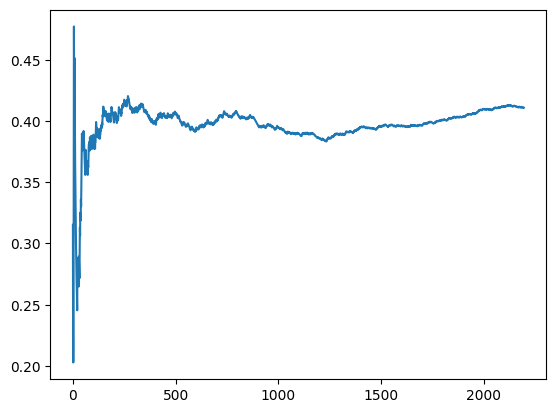

In [38]:
x = confidence['up3.0.conv_path.0.bn']
idx_sorted = np.argsort(x)
y = risk
y_cumsum_sorted_pooling = torch.cumsum(y[idx_sorted], 0) / np.arange(1, len(y) + 1)
plt.plot(y_cumsum_sorted_pooling)

In [61]:
# Batch Norm

device = 'cuda:0'
unet.to(device)

batchnorm_detector = BatchNormMahalanobisDetector(
    swivel='up3.0.conv_path.0.bn',
    device=device,
)
batchnorm_detector.train()
batchnorm_wrapper = BatchNormMahalanobisWrapper(
    model=unet,
    adapters=nn.ModuleList([batchnorm_detector])
)

batchnorm_wrapper.hook_adapters()
batchnorm_wrapper.eval()

eaurc_batchnorm, risk, confidence = get_eaurc_mahalanobis(
    wrapper=batchnorm_wrapper,
    data=raw_data['A'],
    net_out=DATA_KEY,
    device=device
)
eaurc, aurc, risks, weights = eaurc_batchnorm['up3.0.conv_path.0.bn']
# plt.plot(risks[:-1], weights)
print(f'EAURC: {eaurc}')

tensor(1.) tensor(0.0382)
1 1 torch.Size([2196])
EAURC: 0.17392657291963623


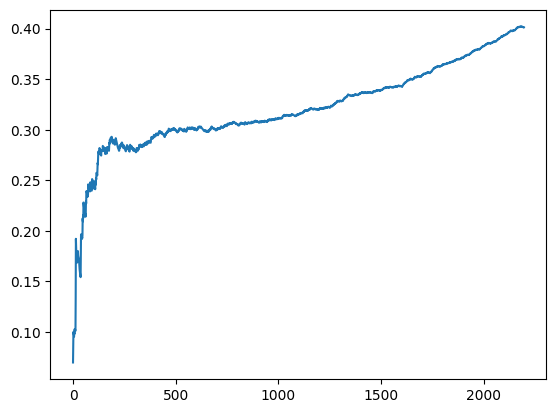

In [59]:
x = confidence['up3.0.conv_path.0.bn']
idx_sorted = np.argsort(x)
y = risk
y_cumsum_sorted_batchnorm = torch.cumsum(y[idx_sorted], 0) / np.arange(1, len(y) + 1)
plt.plot(y_cumsum_sorted_batchnorm)

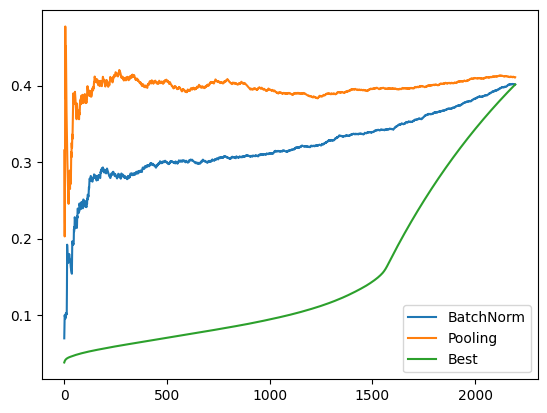

In [48]:
best_risk = torch.cumsum(torch.sort(risk)[0], 0) / np.arange(1, len(y) + 1)
plt.plot(y_cumsum_sorted_batchnorm)
plt.plot(y_cumsum_sorted_pooling)
plt.plot(best_risk)
plt.legend(['BatchNorm', 'Pooling', 'Best'])

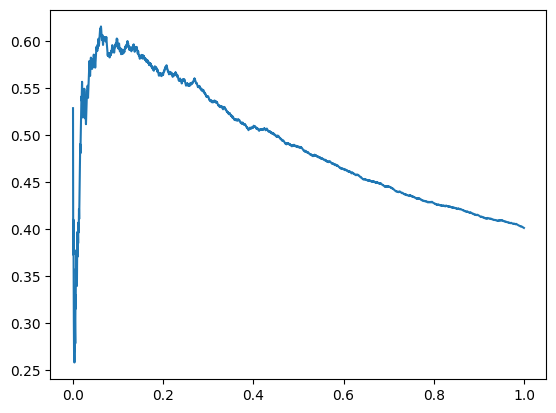

In [54]:
plt.plot(torch.cumsum(reversed(weights), 0), reversed(risks[:-1]))

In [51]:
len(weights)

2195